<!-- Copyright (c) 2021-2022, InterDigital Communications, Inc
All rights reserved.

Redistribution and use in source and binary forms, with or without 
modification, are permitted (subject to the limitations in the disclaimer 
below) provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, 
this list of conditions and the following disclaimer.
* Redistributions in binary form must reproduce the above copyright notice, 
this list of conditions and the following disclaimer in the documentation 
and/or other materials provided with the distribution.
* Neither the name of InterDigital Communications, Inc nor the names of its 
contributors may be used to endorse or promote products derived from this 
software without specific prior written permission.

NO EXPRESS OR IMPLIED LICENSES TO ANY PARTY'S PATENT RIGHTS ARE GRANTED BY 
THIS LICENSE. THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND 
CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT 
NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A 
PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER 
OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, 
EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, 
PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; 
OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, 
WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR 
OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF 
ADVISED OF THE POSSIBILITY OF SUCH DAMAGE. -->

# CompressAI inference demo + DNA coding

In [72]:
import math
import io
import torch
from torchvision import transforms
import torchvision
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt

from pytorch_msssim import ms_ssim
from compressai.zoo import bmshj2018_factorized
from ipywidgets import interact, widgets

In [73]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Load a pretrained model

In [74]:
net = bmshj2018_factorized(quality=3, pretrained=True).eval().to(device)
# change quality to 4, 8 

In [75]:
print(f'Parameters: {sum(p.numel() for p in net.parameters())}')

Parameters: 2998147


### Load image and convert to 4D float tensor

In [76]:
img = Image.open('./assets/stmalo_fracape.png').convert('RGB')
#img = Image.open('kodim04.png').convert('RGB')
x = transforms.ToTensor()(img).unsqueeze(0).to(device)                  # tensor

In [77]:
width, height = img.size
# top: int, left: int, height: int, width: int
left = 478
top = 3
right = 280
bottom = 200
img = torchvision.transforms.functional.crop(img,top, left, bottom, right)
type(img)
x = transforms.ToTensor()(img).unsqueeze(0).to(device)                  # tensor

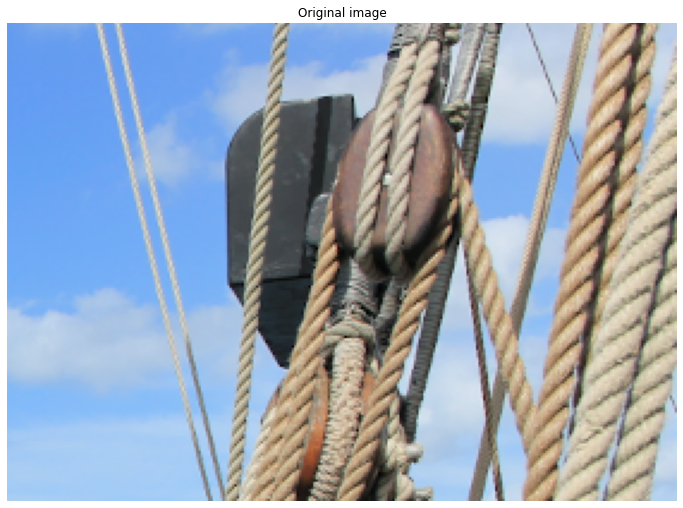

In [78]:
%matplotlib inline
plt.figure(figsize=(12, 9))
plt.axis('off')
plt.title('Original image')
plt.imshow(img)
plt.show()

### Run the network

In [79]:
# NO LO USO
with torch.no_grad():
    out_net = net.forward(x)
    out_net['x_hat'].clamp_(0, 1)

We obtain a dictionary with the decoded/reconstructed image tensor `x_hat` and the latent(s) likelihoods.

### Visualize result

Convert the Tensor back to a 2D Pillow image:

In [80]:
# NO LO USO
rec_net = transforms.ToPILImage()(out_net['x_hat'].squeeze().cpu())

In [81]:
# NO LO USO
diff = torch.mean((out_net['x_hat'] - x).abs(), axis=1).squeeze().cpu()

RuntimeError: The size of tensor a (288) must match the size of tensor b (280) at non-singleton dimension 3

# RUN 

###### Check how different are the images without entropy coding (DNA): a) without Quantization b) with quantization

#### a) without Quantisation

In [82]:
with torch.no_grad():
    y = net.g_a(x)
    #y_hat, y_likelihoods = net.entropy_bottleneck(y)

In [83]:
with torch.no_grad():
    x_hat_y = net.g_s(y).clamp_(0, 1)
    #x_hat_y_hat = net.g_s(y_hat).clamp_(0, 1)

im1 = x_hat_y

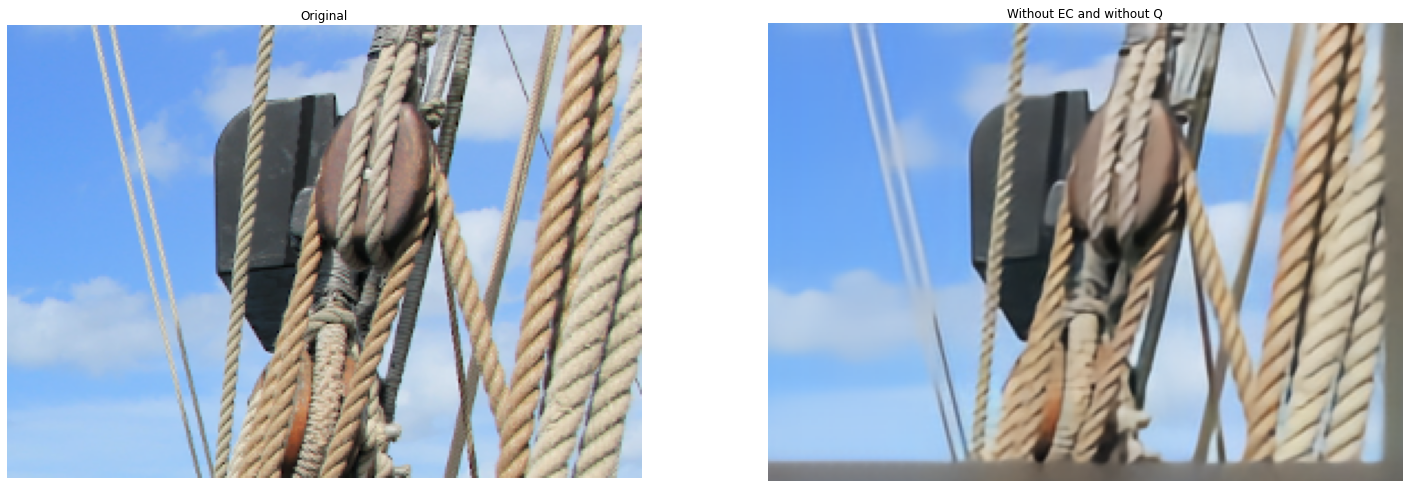

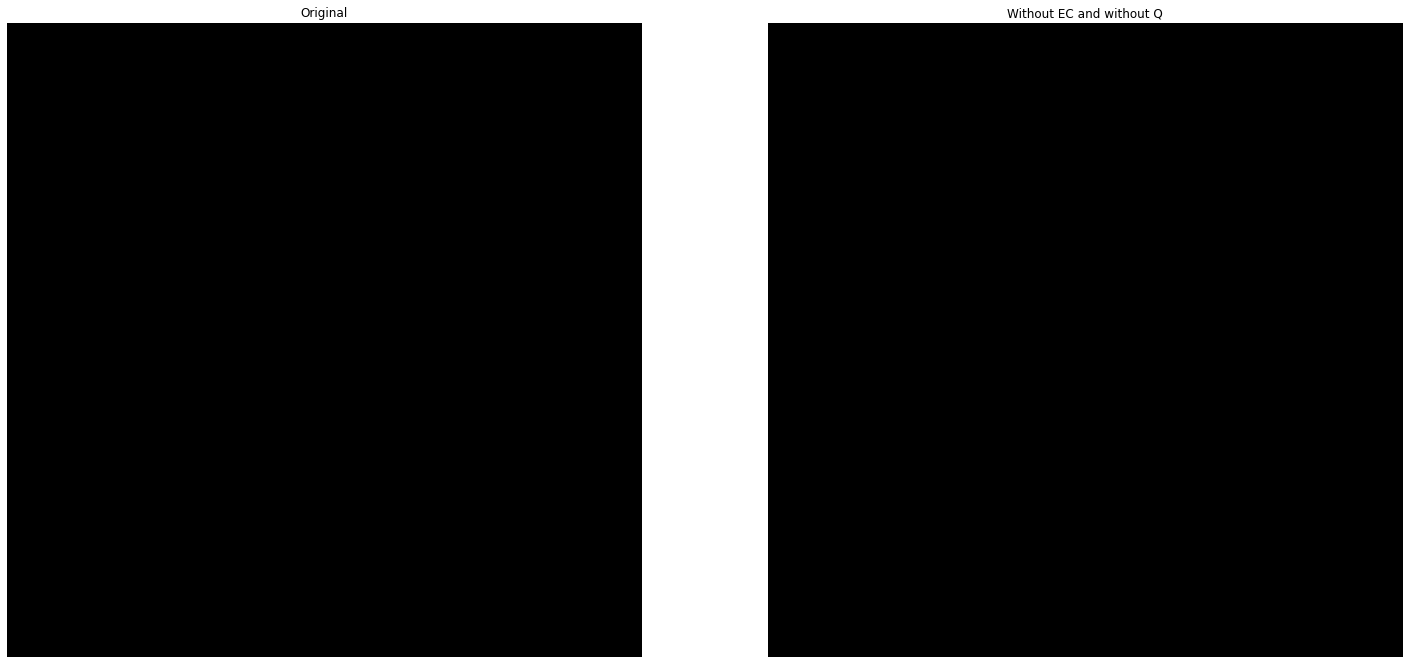

In [84]:
im_wo_e_wo_q = transforms.ToPILImage()(x_hat_y.squeeze().cpu())
plt.figure(figsize=(25, 20))
plt.subplot(121)
plt.imshow(img)
plt.title('Original')
plt.axis('off')
plt.subplot(122)
plt.title('Without EC and without Q')
plt.axis('off')
plt.imshow(im_wo_e_wo_q)
plt.show()

plt.figure(figsize=(25, 20))
plt.subplot(121)
plt.imshow(img.crop((468, 212, 768, 512)))
plt.title('Original')
plt.axis('off')
plt.subplot(122)
plt.title('Without EC and without Q')
plt.axis('off')
plt.imshow(im_wo_e_wo_q.crop((468, 212, 768, 512)))
plt.show()

#### b) with Quantisation 

In [86]:
with torch.no_grad():
    y = net.g_a(x)
    #y_hat, y_likelihoods = net.entropy_bottleneck(y)
    

In [87]:
# change tensor type to double. QUANTIZATION
y_hat = y.round()
y_hat = y_hat.to(dtype = torch.float32)


In [88]:
with torch.no_grad():
    #x_hat_y = net.g_s(y).clamp_(0, 1)
    x_hat_y_hat2 = net.g_s(y_hat).clamp_(0, 1)

    
im2 = x_hat_y_hat2

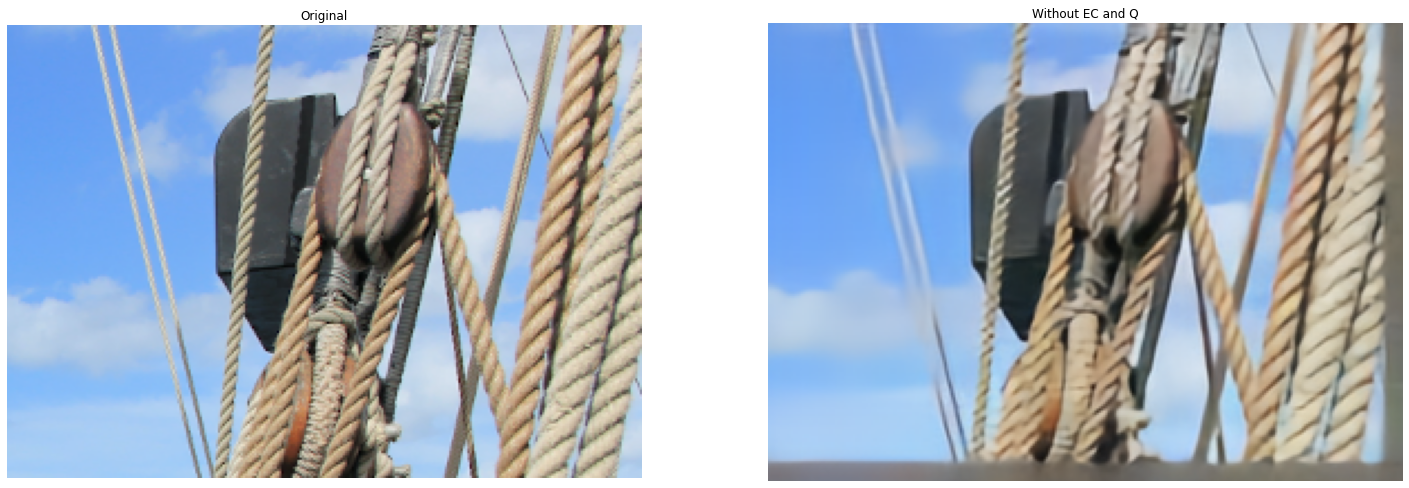

In [89]:
im_wo_e_wq = transforms.ToPILImage()(x_hat_y_hat2.squeeze().cpu())
plt.figure(figsize=(25, 20))
plt.subplot(121)
plt.imshow(img)
plt.title('Original')
plt.axis('off')
plt.subplot(122)
plt.title('Without EC and Q')
plt.axis('off')
plt.imshow(im_wo_e_wq)
plt.show()

Difference with and without quantisation (WITHOUT ENTROPY CODING)

In [63]:
dif = im1-im2
print('max', dif.max(), 'min', dif.min())

max tensor(0.1691) min tensor(-0.1370)


## USING y

###### Check how different are the images with and without entropy coding (DNA): a) with entropy coding b) without entropy coding

a) with entropy coding

In [90]:
with torch.no_grad():
    y = net.g_a(x)
    #y_hat, y_likelihoods = net.entropy_bottleneck(y)  
print(y.size())

torch.Size([1, 192, 13, 18])


In [91]:
# QUANTISE
#y_hat = y.round()
#y_hat = y_hat.to(dtype = torch.float32)
y_hat = y
y_hat_np = np.array(y_hat)
np.save('y_hat.npy', y_hat_np)

In [92]:
print(y_hat_np.shape)
print(abs(y_hat).min(), y_hat.max())

(1, 192, 13, 18)
tensor(1.9619e-07) tensor(39.2989)


**DNA CODER**

In [120]:
#y_cod_out = np.load('y_cod_out_kodim04/y_cod_out_q4.npy')

y_cod_out = np.load('y_cod_out.npy')
y_cod_out = torch.Tensor(y_cod_out)
#y_cod_out = y_cod_out.to(dtype = torch.float32)
print(y_cod_out.shape)
y_hat = y_cod_out
print('max',(y - y_cod_out).max(),'min', (y - y_cod_out).min(),'mean', (y-y_cod_out).mean())

torch.Size([1, 192, 13, 18])
max tensor(51.7948) min tensor(-56.3508) mean tensor(20.1035)


In [124]:
print(y_hat.shape)
with torch.no_grad():
    #x_hat_y = net.g_s(y).clamp_(0, 1)
    x_hat_y_hat = net.g_s(y_hat).clamp_(0, 1)

im3 = x_hat_y_hat

print(x_hat_y_hat.shape)

torch.Size([1, 192, 13, 18])
torch.Size([1, 3, 208, 288])


In [117]:
compute_psnr(x_hat_y_hat3, x)

RuntimeError: The size of tensor a (288) must match the size of tensor b (280) at non-singleton dimension 3

In [1]:
im_we_wq = transforms.ToPILImage()(x_hat_y_hat3.squeeze().cpu())
plt.figure(figsize=(25, 20))
plt.subplot(121)
plt.imshow(img)
plt.title('Original')
plt.axis('off')
plt.subplot(122)
plt.title('With EC and with Q')
plt.axis('off')
plt.imshow(im_we_wq)
plt.show()

NameError: name 'transforms' is not defined

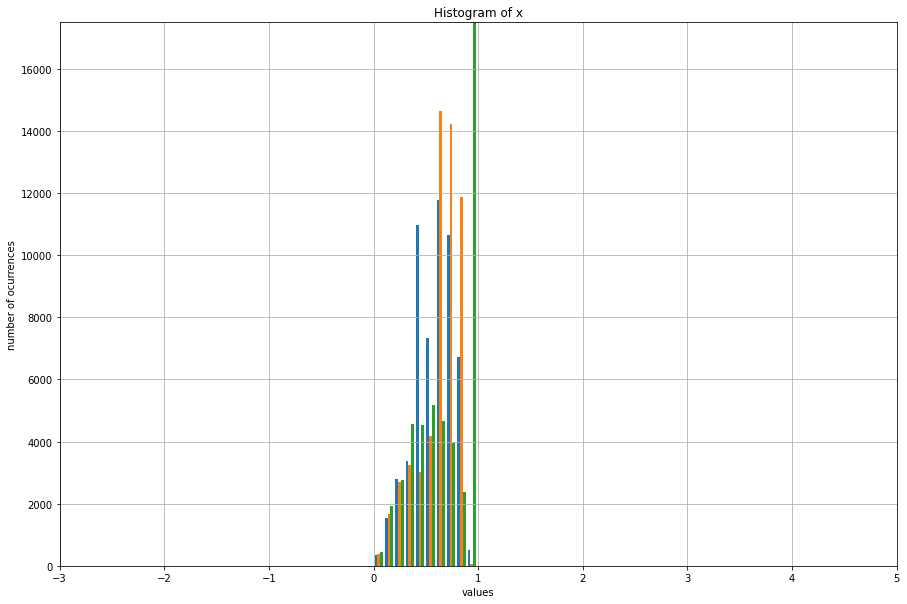

In [102]:
a = np.reshape(x, (3,-1))

plt.figure(figsize=(15,10))
n, bins, patches = plt.hist(a)

plt.xlabel('values')
plt.ylabel('number of ocurrences')
plt.title('Histogram of x')
plt.xlim(-3, 5)
plt.ylim(0, 17500)
plt.grid(True)
plt.show()

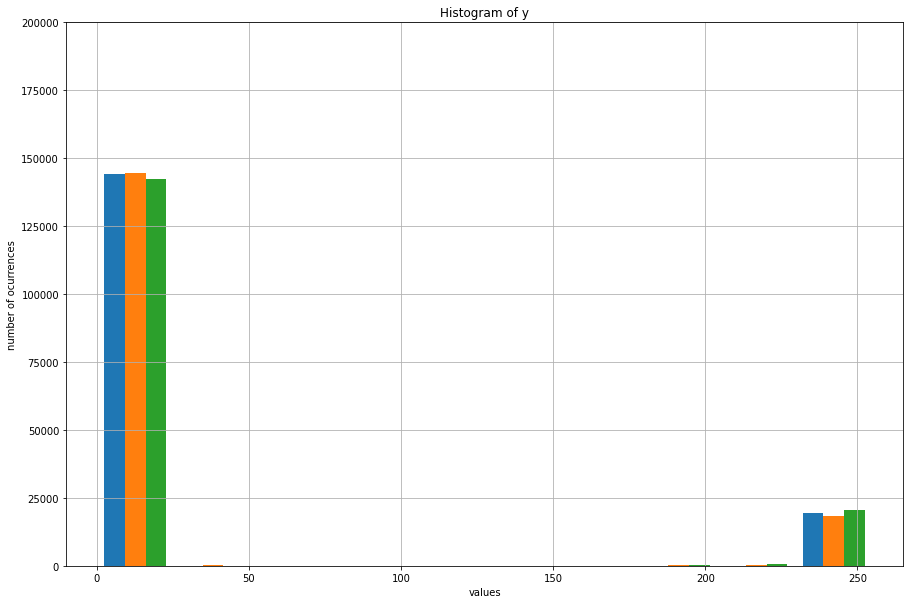

In [103]:
b = np.reshape(y_cod_out, (3,-1))

plt.figure(figsize=(15,10))
n, bins, patches = plt.hist(b)

plt.xlabel('values')
plt.ylabel('number of ocurrences')
plt.title('Histogram of y')
plt.xlim(-10, 265)
plt.ylim(0, 200000)
plt.grid(True)
plt.show()

In [108]:
# see how many counts does every unique value have
a2, a3 = torch.unique(x, sorted=True, return_inverse=False, return_counts=True, dim=None)
a2, a3

(tensor([0.0000, 0.0039, 0.0078, 0.0118, 0.0157, 0.0196, 0.0235, 0.0275, 0.0314,
         0.0353, 0.0392, 0.0431, 0.0471, 0.0510, 0.0549, 0.0588, 0.0627, 0.0667,
         0.0706, 0.0745, 0.0784, 0.0824, 0.0863, 0.0902, 0.0941, 0.0980, 0.1020,
         0.1059, 0.1098, 0.1137, 0.1176, 0.1216, 0.1255, 0.1294, 0.1333, 0.1373,
         0.1412, 0.1451, 0.1490, 0.1529, 0.1569, 0.1608, 0.1647, 0.1686, 0.1725,
         0.1765, 0.1804, 0.1843, 0.1882, 0.1922, 0.1961, 0.2000, 0.2039, 0.2078,
         0.2118, 0.2157, 0.2196, 0.2235, 0.2275, 0.2314, 0.2353, 0.2392, 0.2431,
         0.2471, 0.2510, 0.2549, 0.2588, 0.2627, 0.2667, 0.2706, 0.2745, 0.2784,
         0.2824, 0.2863, 0.2902, 0.2941, 0.2980, 0.3020, 0.3059, 0.3098, 0.3137,
         0.3176, 0.3216, 0.3255, 0.3294, 0.3333, 0.3373, 0.3412, 0.3451, 0.3490,
         0.3529, 0.3569, 0.3608, 0.3647, 0.3686, 0.3725, 0.3765, 0.3804, 0.3843,
         0.3882, 0.3922, 0.3961, 0.4000, 0.4039, 0.4078, 0.4118, 0.4157, 0.4196,
         0.4235, 0.4275, 0.4

In [109]:
# see how many counts does every unique value have
b2, b3 = torch.unique(x_hat_y_hat3, sorted=True, return_inverse=False, return_counts=True, dim=None)
b2, b3

(tensor([0., 1.]), tensor([583687, 595961]))

In [ ]:
(x - x_hat_y_hat3).max(), (x - x_hat_y_hat3).min()
a=transforms.ToPILImage()(x_hat_y_hat3.squeeze().cpu())
a.save("st_q8.png")

In [ ]:
plt.figure(figsize=(20,15))
plt.subplot(121)
plt.title('Original cropped')
plt.axis('off')
plt.imshow(img.crop((468, 212, 768, 512)))
plt.subplot(122)
plt.title('With EC and with Q cropped')
plt.axis('off')
plt.imshow(im_we_wq.crop((468, 212, 768, 512)))
plt.show()
'''
plt.figure(figsize=(20, 15))
plt.subplot(121)
plt.title('Without EC and without Q')
plt.axis('off')
plt.imshow(im_wo_e_wo_q.crop((468, 212, 768, 512)))
plt.subplot(122)
plt.title('Without EC and with Q')
plt.axis('off')
plt.imshow(im_wo_e_wq.crop((468, 212, 768, 512)))
plt.show()'''

#### Difference between with and without entropy coding

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.title('With EC and with Q cropped')
plt.axis('off')
plt.imshow(im_we_wq.crop((468, 212, 768, 512)))
plt.subplot(122)
plt.title('Without EC and Without Q cropped')
plt.axis('off')
plt.imshow(im_wo_e_wo_q.crop((468, 212, 768, 512)))
plt.show()

diff=x_hat_y_hat3-x_hat_y_hat2
print(diff)

b) without entropy coding

In [ ]:
with torch.no_grad():
    y = net.g_a(x)
    y_hat, y_likelihoods = net.entropy_bottleneck(y)

In [ ]:
#new_y_hat = y_hat.to(dtype = torch.float32)
#y_hat = new_y_hat
new_y = y.to(dtype = torch.float32)
y = new_y

In [ ]:
with torch.no_grad():
    x_hat_y = net.g_s(y).clamp_(0, 1)
    x_hat_y_hat = net.g_s(y_hat).clamp_(0, 1)
#im4 = x_hat_y_hat
im4 = x_hat_y

In [ ]:
#img = transforms.ToPILImage()(x_hat_y_hat.squeeze().cpu())
img = transforms.ToPILImage()(x_hat_y.squeeze().cpu())
plt.figure(figsize=(12, 9))
plt.axis('off')
plt.imshow(img)
plt.show()

Difference with and without ENTROPY CODING

In [ ]:
dif = im3-im4
print('max', dif.max(), 'min', dif.min())

#### Compute the 'bitrate' in ACGT : (number of nucleotides) / (number of pixels)

In [ ]:
len_oligos = 19571
num_nt = 200*len_oligos
#width, height = Image.open('./assets/stmalo_fracape.png').size
width, height = Image.open('kodim04.png').size
num_px = width*height

In [ ]:
ACGT_rate = num_nt/num_px
ACGT_rate

#### Compute the PSNR between the compressed image and the original one

In [ ]:
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [ ]:
def _psnr(a, b):
        a = np.asarray(a).astype(np.float32)
        b = np.asarray(b).astype(np.float32)
        mse = np.mean(np.square(a - b))
        return 20*math.log10(255.) -10. * math.log10(mse)

In [113]:
def compute_psnr(a, b):
    mse = torch.mean((a - b)**2).item()
    return -10 * math.log10(mse)

In [ ]:
compute_psnr(x_hat_y_hat3,x)

## USING y_hat MALOOOOOOOOOOO NO USAR

###### Check how different are the images with and without entropy coding (DNA): a) with entropy coding b) without entropy coding

a) with entropy coding

In [ ]:
with torch.no_grad():
    y = net.g_a(x)
    y_hat, y_likelihoods = net.entropy_bottleneck(y)

In [ ]:
#new_y_hat = y_hat.int()   # torch.round()
new_y_hat = y_hat
new_y_hat_np = np.array(new_y_hat)
np.save('new_y_hat.npy', new_y_hat_np)

**DNA CODER**

In [ ]:
y_cod_out = np.load('y_cod_out.npy')
y_cod_out = torch.Tensor(y_cod_out)
y_cod_out = y_cod_out.to(dtype = torch.float32)
y_hat = y_cod_out

In [ ]:
with torch.no_grad():
    x_hat_y = net.g_s(y).clamp_(0, 1)
    x_hat_y_hat = net.g_s(y_hat).clamp_(0, 1)
im3 = x_hat_y_hat

In [ ]:
img = transforms.ToPILImage()(x_hat_y_hat.squeeze().cpu())
plt.figure(figsize=(12, 9))
plt.axis('off')
plt.imshow(img)
plt.show()

b) without entropy coding

In [ ]:
with torch.no_grad():
    y = net.g_a(x)
    y_hat, y_likelihoods = net.entropy_bottleneck(y)

In [ ]:
new_y_hat = y_hat.to(dtype = torch.float32)
y_hat = new_y_hat

In [ ]:
with torch.no_grad():
    x_hat_y = net.g_s(y).clamp_(0, 1)
    x_hat_y_hat = net.g_s(y_hat).clamp_(0, 1)
im4 = x_hat_y_hat

In [ ]:
img = transforms.ToPILImage()(x_hat_y_hat.squeeze().cpu())
plt.figure(figsize=(12, 9))
plt.axis('off')
plt.imshow(img)
plt.show()

Difference with and without ENTROPY CODING

In [ ]:
dif = im3-im4
print('max', dif.max(), 'min', dif.min())

In [ ]:
y_hat_np = np.array(y_hat)
y_hat_np.shape

In [ ]:
a = np.reshape(y_hat_np, [192, : ])

In [ ]:
def quantize(self, inputs, mode, means ):
       # self, inputs: Tensor, mode: str, means: Optional[Tensor] = None
  #  ) -> Tensor:
        if mode not in ("noise", "dequantize", "symbols"):
            raise ValueError(f'Invalid quantization mode: "{mode}"')

        if mode == "noise":
            half = float(0.5)
            noise = torch.empty_like(inputs).uniform_(-half, half)
            inputs = inputs + noise
            return inputs

        outputs = inputs.clone()
        if means is not None:
            outputs -= means

        outputs = torch.round(outputs)

        if mode == "dequantize":
            if means is not None:
                outputs += means
            return outputs

        assert mode == "symbols", mode
        outputs = outputs.int()
        return outputs

In [ ]:
out = quantize(1,y_hat, 'noise', 0)
torch.min(out)

In [ ]:
def mse(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.square(np.subtract(actual,pred)).mean() 

In [ ]:
a = x_hat_y
b = 
mse(a,b)

In [ ]:
#NOTASSSSSSSSSSSSSSS

#torch.save(y, 'y_tensor.pt')   //   torch.load()

#q = np.transpose(new_y_hat_np_array)                        


img = transforms.ToPILImage()(x_hat_y.squeeze().cpu())
plt.imshow(img)
img.save("img.png")

# quantize a tensor
y_quantized = torch.quantize_per_tensor(y, scale=0.1, zero_point = 0, dtype = torch.quint8)


print(type(rec_net))
#rec_net.save("rec_net.png")